# Lab 1: Planar transformations and image rectification

The two main goals of this first lab are the following:

1) Get more familiar with the hierarchy of 2D transformations. <br>

2) Image rectification: Removal of the projective distortion of an image of a planar object.

This notebook combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

## **1. Image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to an image.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so that it contains the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [25]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil
from utils import line_draw, plot_img

def apply_H(I: np.ndarray, H: np.ndarray) -> np.ndarray:
    height, width, channels = I.shape
    
    # Transform corners to find output image size
    corners = np.array([
        [0, 0, 1],
        [width-1, 0, 1],
        [0, height-1, 1],
        [width-1, height-1, 1]
    ])
    
    # Transform corners
    corners_transformed = (H @ corners.T).T
    corners_transformed = corners_transformed / corners_transformed[:, 2:]
    
    # Calculate output image bounds
    xmin = np.floor(corners_transformed[:, 0].min()).astype(int)
    xmax = np.ceil(corners_transformed[:, 0].max()).astype(int)
    ymin = np.floor(corners_transformed[:, 1].min()).astype(int)
    ymax = np.ceil(corners_transformed[:, 1].max()).astype(int)
    
    # Calculate output image size
    out_width = xmax - xmin + 1
    out_height = ymax - ymin + 1
    
    # Create output coordinate grid
    y_coords, x_coords = np.meshgrid(
        np.arange(out_height),
        np.arange(out_width),
        indexing='ij'
    )
    
    # Add shift to account for negative coordinates
    x_coords = x_coords + xmin
    y_coords = y_coords + ymin
    
    # Create homogeneous coordinates
    homogeneous_coords = np.stack([
        x_coords.ravel(),
        y_coords.ravel(),
        np.ones_like(x_coords.ravel())
    ])
    
    # Apply inverse homography
    H_inv = np.linalg.inv(H)
    transformed_coords = H_inv @ homogeneous_coords
    
    # Normalize coordinates
    transformed_coords = transformed_coords / transformed_coords[2]
    source_y = transformed_coords[1].reshape(out_height, out_width)
    source_x = transformed_coords[0].reshape(out_height, out_width)
    coords = np.stack([source_y, source_x])
    
    # Apply interpolation for each channel
    output_image = np.zeros((out_height, out_width, channels), dtype=np.uint8)
    for channel in range(channels):
        output_image[:, :, channel] = map_coordinates(
            I[:, :, channel],
            coords,
        )
        
    return output_image

### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H that produces a similarity transformation. </span>

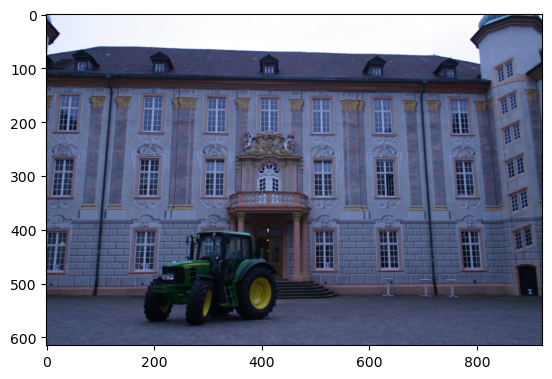

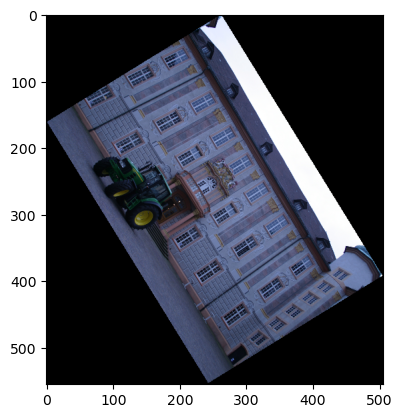

In [27]:
# theta = 45 , s = 0.5, t = [0,0]
H = np.array([[0.5*np.cos(45),-0.5*np.sin(45),2],[0.5*np.sin(45), 0.5*np.cos(45),2],[0,0,1]])

img_path = "./Data/0005_s.png"
I = Image.open(img_path)

I_sim = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_sim)

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H that produces an affine transformation.  </span>

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

<span style='color:Green'> - Verify that the proper sequence of the four previous
transformations, applied over the image `I` **one by one**, produces the same transformed image as before.  </span>

Matrix H:  [[ 0.52532199 -0.42545176  2.        ]
 [ 0.          0.52532199  2.        ]
 [ 0.          0.          1.        ]]


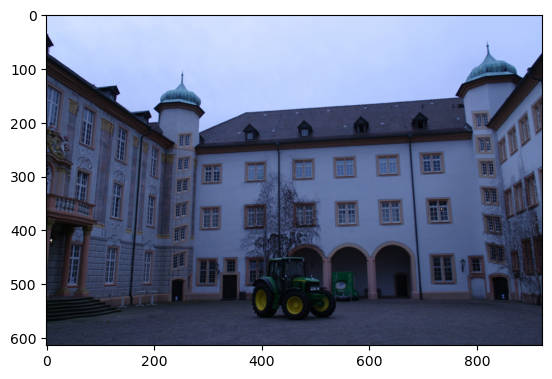

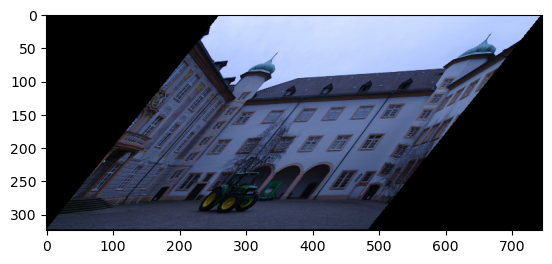

In [17]:
#Complete the code below by generating a matrix H that produces an affine transformation.
H = np.array([[np.cos(45),-0.5*np.sin(45),2],[0*np.sin(45), np.cos(45),2],[0,0,1]])
print("Matrix H: ",H)
I_aff = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_aff)

In [18]:
from numpy.linalg import svd, det


def decompose_affine(H):
    # Extract the 2x2 linear part
    A = H[:2, :2]
    
    # Extract translation
    t = H[:2, 2]
    
    # Create translation matrix
    T = np.eye(3)
    T[:2, 2] = t
    
    # Perform SVD on the linear part
    U, S, Vt = svd(A)
    
    # First rotation (from right)
    R1 = np.eye(3)
    R1[:2, :2] = U  # Changed from Vt.T to U
    
    # Scaling matrix
    S_mat = np.eye(3)
    S_mat[0, 0] = S[0]
    S_mat[1, 1] = S[1]
    
    # Second rotation (from left)
    R2 = np.eye(3)
    R2[:2, :2] = Vt
    
    return T, R2, S_mat, R1

In [19]:
#Decompose the affinity in four transformations: two rotations, a scale, and a translation 
T, R2, S, R1 = decompose_affine(H)
print("T:", T)
print("R2:", R2)
print("S:", S)
print("R1:", R1)

T: [[1. 0. 2.]
 [0. 1. 2.]
 [0. 0. 1.]]
R2: [[ 0.55886599 -0.82925799  0.        ]
 [ 0.82925799  0.55886599  0.        ]
 [ 0.          0.          1.        ]]
S: [[0.77948464 0.         0.        ]
 [0.         0.35403288 0.        ]
 [0.         0.         1.        ]]
R1: [[ 0.82925799  0.55886599  0.        ]
 [-0.55886599  0.82925799  0.        ]
 [ 0.          0.          1.        ]]


In [20]:
# Verify that the product of the four previous transformations produces the same matrix H as above
print("Reconstructed Matrix H", T @ R1 @ S @ R2)

Reconstructed Matrix H [[ 5.25321989e-01 -4.25451762e-01  2.00000000e+00]
 [ 9.25217669e-17  5.25321989e-01  2.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


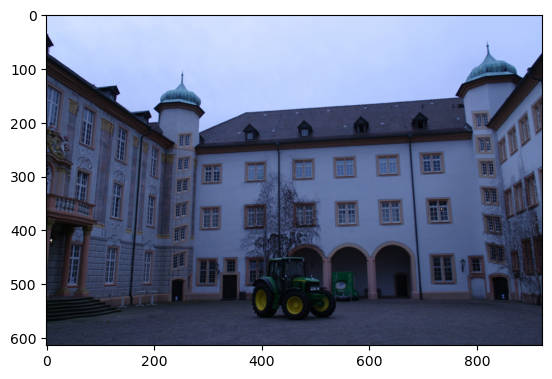

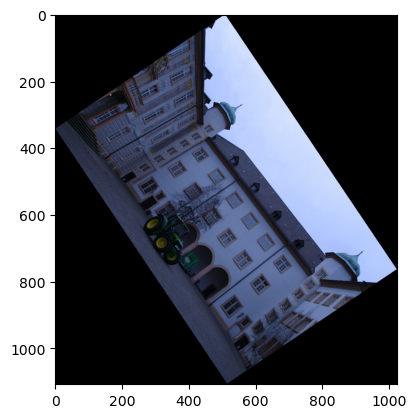

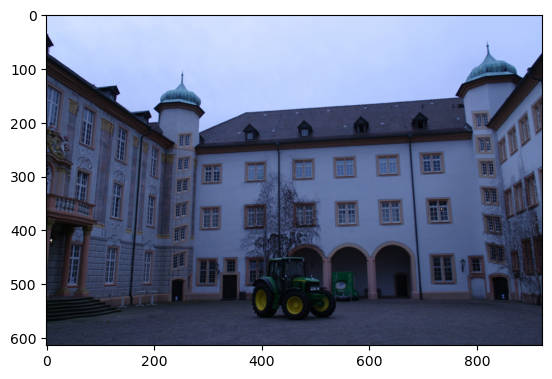

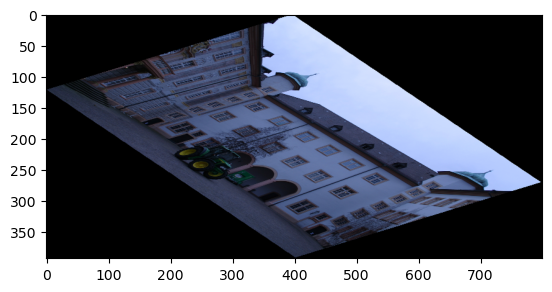

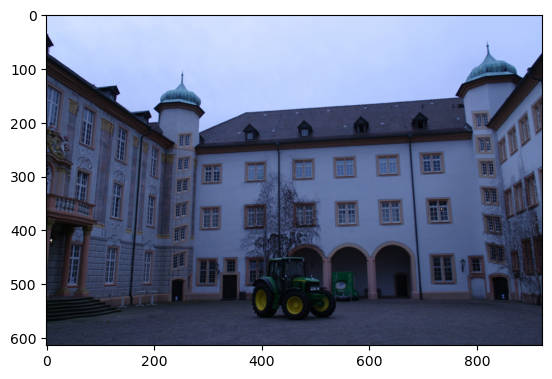

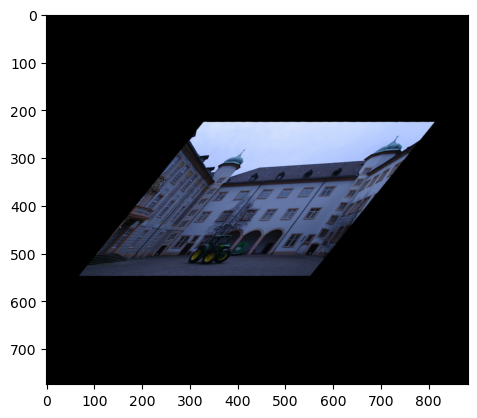

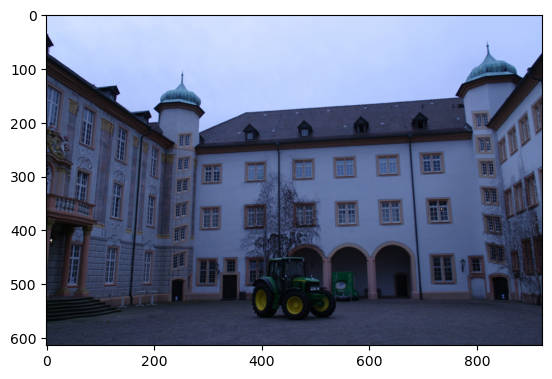

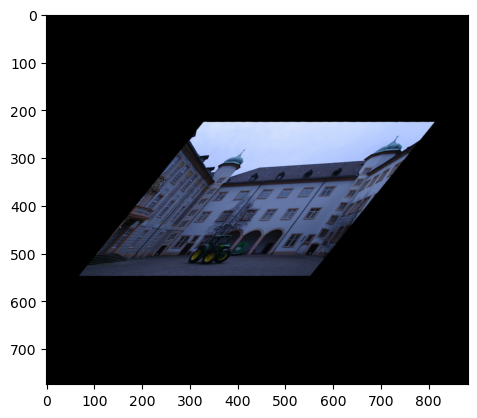

In [21]:
#Verify that the proper sequence of the four previous transformations, applied over the image `I` **one by one**, produces the same transformed image as before
It1 = apply_H(np.array(I), R2)

plot_img(I)
plot_img(It1)

It2 = apply_H(np.array(It1), S)

plot_img(I)
plot_img(It2)

It3 = apply_H(np.array(It2), R1)

plot_img(I)
plot_img(It3)

It4 = apply_H(np.array(It3), T)

plot_img(I)
plot_img(It4)

### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H that produces a projective transformation.  </span>

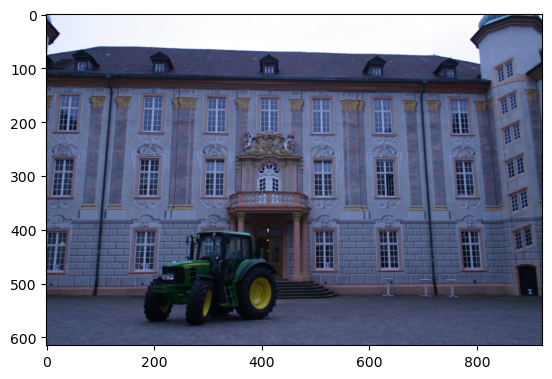

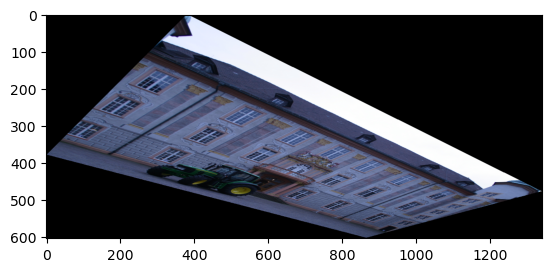

In [13]:
H = np.array([[2,-1,-1],[1, 1,3],[0.001,0.001,1]])
I_proj = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_proj)

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

### **2.1 Vanishing points estimated semi-automatically**

First, we will perform affine rectification by computing the vanishing points in a semi-automatic way. Line segments in the image will be detected automatically and then pairs of segments corresponding to imaged parallel lines will be manually selected. The segments are detected by the Line Segment Detector algorithm (paper [1], demo and code available in [2]). The result of this algorithm in the images of interest is already provided. The initial and final points of each detected segment are provided in a text file. The code below shows how to read the corresponding points for a certain segment given its index.  

[1] R. Grompone von Gioi, J. Jakubowicz, J.-M. Morel, G. Randall. LSD: a Line Segment Detector. , Image Processing On Line, 2, , pp. 35–55, 2012.

[2] http://www.ipol.im/pub/art/2012/gjmr-lsd/

In [14]:
# load images and lines
img_path = "./Data/0000_s.png"
I = Image.open(img_path)

lines_path = "./Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 423 # line index (starting from 0)
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 239
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 711
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 564
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

<span style='color:Green'> - Compute the lines l1, l2, l3, l4, that pass through the different pairs of points.  </span>

In [15]:
l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)

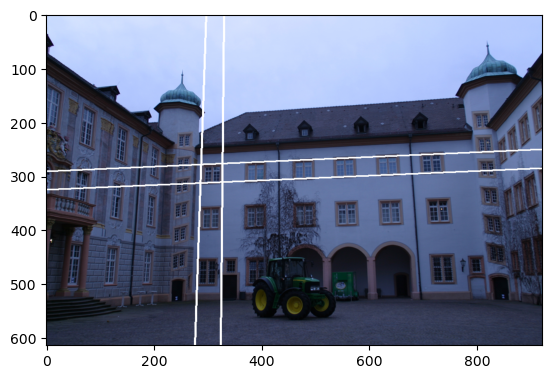

In [16]:
# show the chosen lines in the image
canv = ImageDraw.Draw(I)
point_color = (0, 0, 255)
line_draw(l1, canv, I.size)
line_draw(l2, canv, I.size)
line_draw(l3, canv, I.size)
line_draw(l4, canv, I.size)

# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I)
I = Image.open(img_path)

<span style='color:Green'> - Compute the homography that affinely rectifies the image. </span>

<span style='color:Green'> - Compute the transformed lines lr1, lr2, lr3, lr4 and
      show the transformed lines in the transformed image. </span>
      
<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>
      
<span style='color:Green'> - Verify, experimentally, that the cross-ratio is preserved after the image rectification (you may choose the endpoints of some detected line segments). </span>


The vanishing line is mapped to: 
[0. 0. 1.]


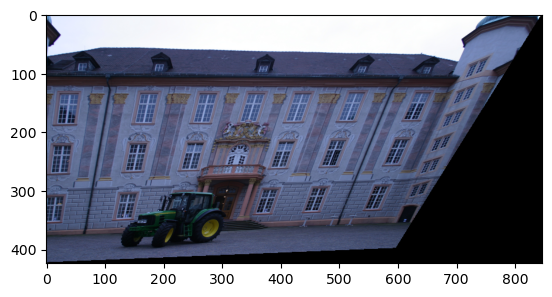

In [31]:
# Compute the homography that affinely rectifies the image
#1. Compute the two vanishing points
p1_v = np.cross(l1,l2)
p2_v = np.cross(l3,l4)

#2. Compute the vanishing line
l_v = np.cross(p1_v,p2_v)
l_v = l_v/l_v[2] #Normalize the vanishing line

#3. Compute H_aff_rect, assuming that the affine matrix Ha is the identity matrix 3 x3
H_aff_rect = np.array([[1, 0, 0],
                       [0, 1, 0],
                       [l_v[0], l_v[1], l_v[2]]])
# compute the transformed image
I_aff_rect = apply_H(np.array(I), H_aff_rect)
plot_img(I_aff_rect)

#Make sure that the line is mapped to [0,0,1]^T

H_inv = LA.inv(H_aff_rect)
print("\nThe vanishing line is mapped to: ")
print((H_inv).T @ l_v)

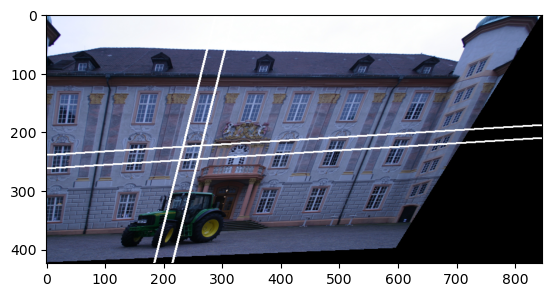

In [32]:
# Compute the transformed lines lr1, lr2, lr3, lr4 and show the transformed lines in the transformed image. 
# compute the transformed lines
lr1 = np.linalg.inv(H_aff_rect).T @ l1
lr2 = np.linalg.inv(H_aff_rect).T @ l2
lr3 = np.linalg.inv(H_aff_rect).T @ l3
lr4 = np.linalg.inv(H_aff_rect).T @ l4


# show the transformed lines in the transformed image
I_tr = Image.fromarray(I_aff_rect, 'RGB')
size = I_tr.size
canv = ImageDraw.Draw(I_tr)
line_draw(lr1, canv, size)
line_draw(lr2, canv, size)
line_draw(lr3, canv, size)
line_draw(lr4, canv, size)

plot_img(I_tr)

In [ ]:
def compute_angle(l1, l2):
    # for reference: https://www.andrew.cmu.edu/course/16-822/projects/ag6/proj1/
    a1, b1, _ = l1
    a2, b2, _ = l2
    cos_theta = (a1 * a2 + b1 * b2) / (np.sqrt(a1**2 + b1**2) * np.sqrt(a2**2 + b2**2))
    cos_theta = max(min(cos_theta, 1.0), -1.0)
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    return round(angle_deg, 2)

In [ ]:
def cross_ratio(lines):
    # Ensure lines are numpy arrays
    lines = [np.array(line) for line in lines]

    # Compute cross-ratio
    numerator = np.dot(np.cross(lines[0], lines[2]), np.cross(lines[1], lines[3]))
    denominator = np.dot(np.cross(lines[0], lines[3]), np.cross(lines[1], lines[2]))

    cross_ratio = numerator / denominator
    return cross_ratio

### **2.2 Vanishing points estimated automatically** 

The vanishing points in an image can be estimated automatically. In this lab, we will use the orthogonal vanishing points estimated by the technique proposed in [3] (code available in [4]), which actually uses the line segments estimated with the LSD algorithm [1] used before.

In this section, we will work with the image 'friends.jpeg'. The estimated vanishing points obtained by [3] are provided in the file 'friends_vps.out' (see code below for more details).

[3] Xiaohu Lu, Jian Yao, Haoang Li, Yahui Liu. 2-Line Exhaustive Searching for Real-Time Vanishing Point Estimation in Manhattan World. IEEE/CVF Winter Conference on Applications of Computer Vision (WACV), 2017.

[4] https://github.com/rayryeng/XiaohuLuVPDetection

<span style='color:Green'> - Perform affine rectification of this image using the appropriate vanishing points automatically detected. **Justify your choice** of vanishing points. </span>

In [ ]:
# Visualize image 'friends.jpeg'

# Visualize image 'friends_vps.jpeg' which shows the different line segments detected by LSD [1] and groups
# them in three different colors according to the different vanishing points they have been associated.

# Load the three orthogonal vanishing points from image 'friends.jpeg' (estimated by [3,4])
vps = np.loadtxt('./Data/friends_vps.out', delimiter=',')
# 'vps' is a numpy array where each row is a vanishing point and each column is a coordinate.
# The first, second and third rows in 'vps' correspond to the vanishing points corresponding to,
# respectively, red, green, and blue directions.


## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

We will work with image 0000.

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.
      
<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>
      


## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>
      
      

## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification of the white facade of image 0000 in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.